# Notebook: Cleaning and Vizualization of Results for the 10 trials 

### Imports

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# CLEANING

### Load Files

In [2]:
products = pd.read_csv(
    '/project/data/compiled_results/raw/Compiled Field Results  for DSI - 2023 Bulk 10 Trial Data.xlsx - Product Dimensions Reference.csv')
facility = pd.read_csv('/project/data/compiled_results/raw/Donated Data 2023 - Compiled Field Results for DSI.xlsx - Facility Dimensions.csv')
all_sheets = pd.read_excel(
    '/project/data/compiled_results/Compiled Field Results  for DSI - 2023 Bulk 10 Trial Data.xlsx',
    sheet_name=None,
    skiprows=1
)

# Extract specific sheets
mass = all_sheets['All Mass Residuals by Prod TAB']
mass = mass.drop(mass.index[0]) 
sa = all_sheets['All SA ImagJ Resids by Prod TAB']

### Clean Products

In [3]:
item_mapping = {'BESICS 12oz Hot Cup': 'PLa-lined Paper Hot Cup 12oz', 
                'BESICS 250mL Leaf Bowl': 'PLA-lined Bagasse Bowl 300mL',
                'BESICS 8oz Hot cup lid': 'CPLA Hot Cup Lid', 
                'BESICS 6" Spoon': 'CPLA Spoon 6', 
                'Kraft butcher paper': 'Positive control - kraft paper 2 ply',
                'Moulded fiber bowl 16oz': 'Fiber Bowl 16oz'}

brand_mapping = {'BESICS 12oz Hot Cup': 'BÉSICS®', 
                 'BESICS 250mL Leaf Bowl': 'BÉSICS®',
                 'BESICS 8oz Hot cup lid': 'CBÉSICS®', 
                 'BESICS 6" Spoon': 'BÉSICS®', 
                 'Kraft butcher paper': 'No name',
                 'Navel orange peel': 'Multiple',
                 'Cellulose bag ': 'Not disclosed',
                 'Coffee Pod': 'Not disclosed',
                 'Bagasse Clamshell 9x9': 'Not disclosed',
                 'Spoon PLA 6"':'Not disclosed',
                 'Straw PHA 8"': 'Not disclosed',
                 'PLA Cold Cup 12oz': 'Not disclosed',
                 'Bin Liner Bag 2.5 gal': 'Not disclosed',
                 'PLA Cold Cup Lid 8oz': 'Not disclosed',
                 'Moulded fiber bowl 16oz': 'Not disclosed'}

products['product_name'] = products[
    'Item Description Refined'
].map(item_mapping).fillna(products['Item Description Refined'])

products['product_brand'] = products[
    'Item Description Refined'
].map(brand_mapping)

products.columns = [col.lower() for col in products.columns]
products.columns = products.columns.str.replace('-', '').str.replace('.', '')
products.columns = products.columns.str.replace(' ', '_')

products.rename(columns={'material_class_ii1': 'material_iii',
                           'material_class_ii': 'material_ii',
                           'material_class_i': 'material_i',
                           }, inplace=True)

products.to_csv('/project/data/compiled_results/processed/products.csv', index=False)

### Clean Facilities

In [4]:
facility.columns = facility.columns.str.rstrip()
facility.columns = facility.columns.str.replace('-', '')
facility.columns = [col.lower() for col in facility.columns]
facility.columns = facility.columns.str.replace(' ', '_')
facility.to_csv('/project/data/compiled_results/processed/facility.csv', index=False)

### Clean Trials

In [5]:
def process_data(dataset, file_name):
    new_names = {
    'Unnamed: 0': 'Facility Name',
    'Unnamed: 1': 'Trial Stage',
    'Unnamed: 2': 'Bag Set',
    'Unnamed: 3': 'Bag number',
    'Lined Hot Cup D' : 'PLa-lined Paper Hot Cup 12oz',
    'Hot Cup Lid A': 'CPLA Hot Cup Lid',
    'Molded Fiber Bowl C': 'Fiber Bowl 16oz', # no match (no C, only B)
    'Spoon C': 'CPLA Spoon 6"',
    'Coffee Pod': 'Coffee Pod 1',
    'Spoon A': 'Spoon PLA 6"',
    'Straw A': 'Straw PHA 8"',
    'Momlded Fiber Bowl B': 'Fiber Bowl 16oz', # misspelled
    'Cold Cup B': 'PLA Cold Cup 12oz',
    'Fiber Clamshell': 'Fiber Clamshell 9x9in',
    'Butcher Paper': 'Kraft Butcher Paper Pink',
    'Navel orange peel': 'Navel Orange Peel Control',
    'Cellulose bag': 'Cellulose bag 5x7in',
    'Lined Hot Cup D.1': 'PLa-lined Paper Hot Cup 12oz', # no match (no D.1, only D)
    'Hot Cup Lid A.1': 'CPLA Hot Cup Lid', # no match (no A.1, only A)
    'Bag B': 'Bin Liner Bag 2.5 gal',
    'Molded Fiber Bowl C.1': 'Fiber Bowl 16oz', # no match (we only have B)
    'Cold Cup Lid B': 'PLA Cold Cup Lid 8oz',
    'Spoon C.1': 'CPLA Spoon 6"' # no match (no C.1, only C)
}
    dataset = dataset.rename(columns=new_names)

    def clean_facility_name(name):
        clean_name = re.sub(r'.*\(', '', name)
        clean_name = re.sub(r'\)', '', clean_name).strip()
        return clean_name

    dataset['Facility Name'] = dataset['Facility Name'].apply(clean_facility_name)

    dataset_long = pd.melt(dataset, id_vars=['Facility Name', 'Trial Stage', 'Bag Set', 'Bag number'],
                           var_name='Product Name', value_name='Percent Residual')

    dataset_long.columns = [col.lower().replace(' ', '_') for col in dataset_long.columns]

    dataset_long.to_csv(file_name, index=False)

    return dataset_long

# Process the 'mass' and 'sa' datasets
processed_mass = process_data(mass, '/project/data/compiled_results/processed/observation_mass.csv')
processed_sa = process_data(sa, '/project/data/compiled_results/processed/observation_area.csv')

# DATA ANALYSIS

## Facility Analysis

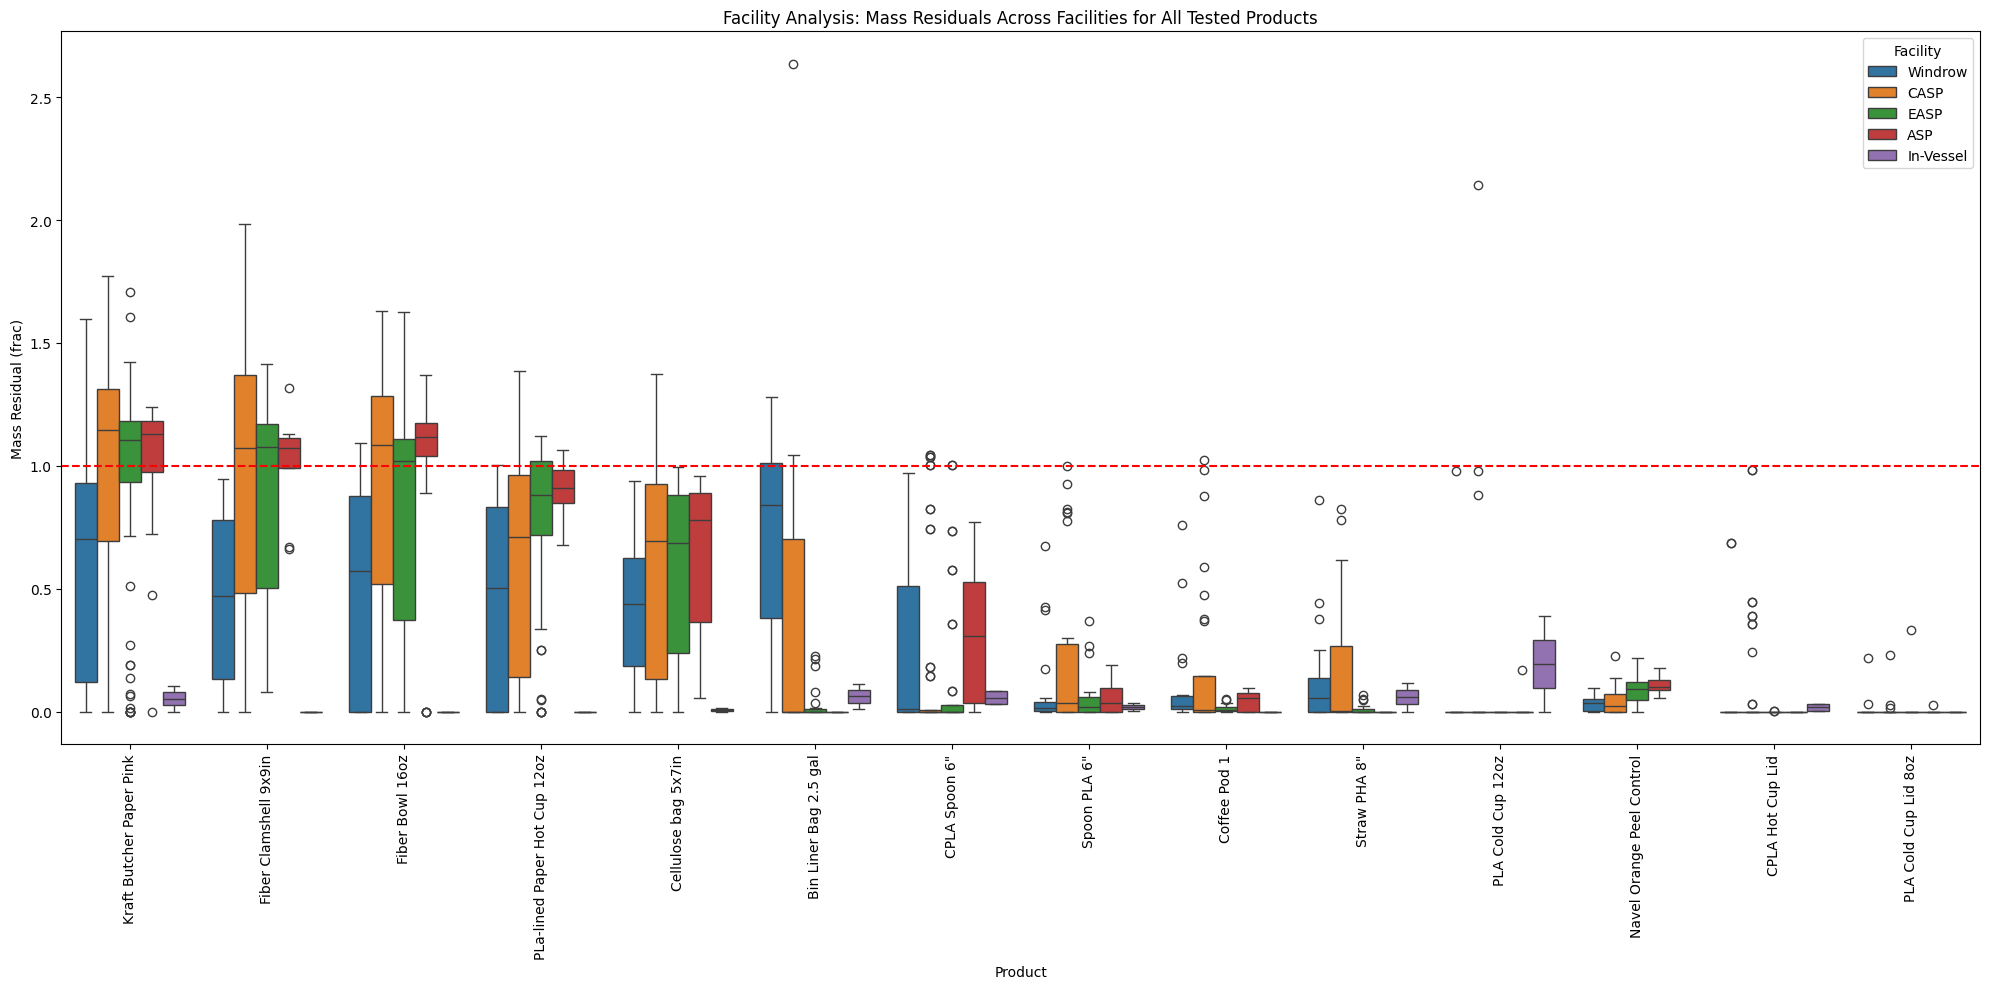

In [68]:
mass_long = pd.read_csv('/project/data/compiled_results/processed/observation_mass.csv')
mass_long['percent_residual'] = pd.to_numeric(
    mass_long['percent_residual'], errors='coerce'
)
product_means_mass = mass_long.groupby(
    'product_name'
)['percent_residual'].mean()
sorted_products_mass = product_means_mass.sort_values(
    ascending=False
).index.tolist()

plt.figure(figsize=(20, 10))
sns.boxplot(x='product_name', y='percent_residual', hue='facility_name', 
            data=mass_long, order=sorted_products_mass)
plt.title('Facility Analysis: Mass Residuals Across Facilities for All Tested Products')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Mass Residual (frac)')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend(title='Facility')
plt.tight_layout()
plt.show()

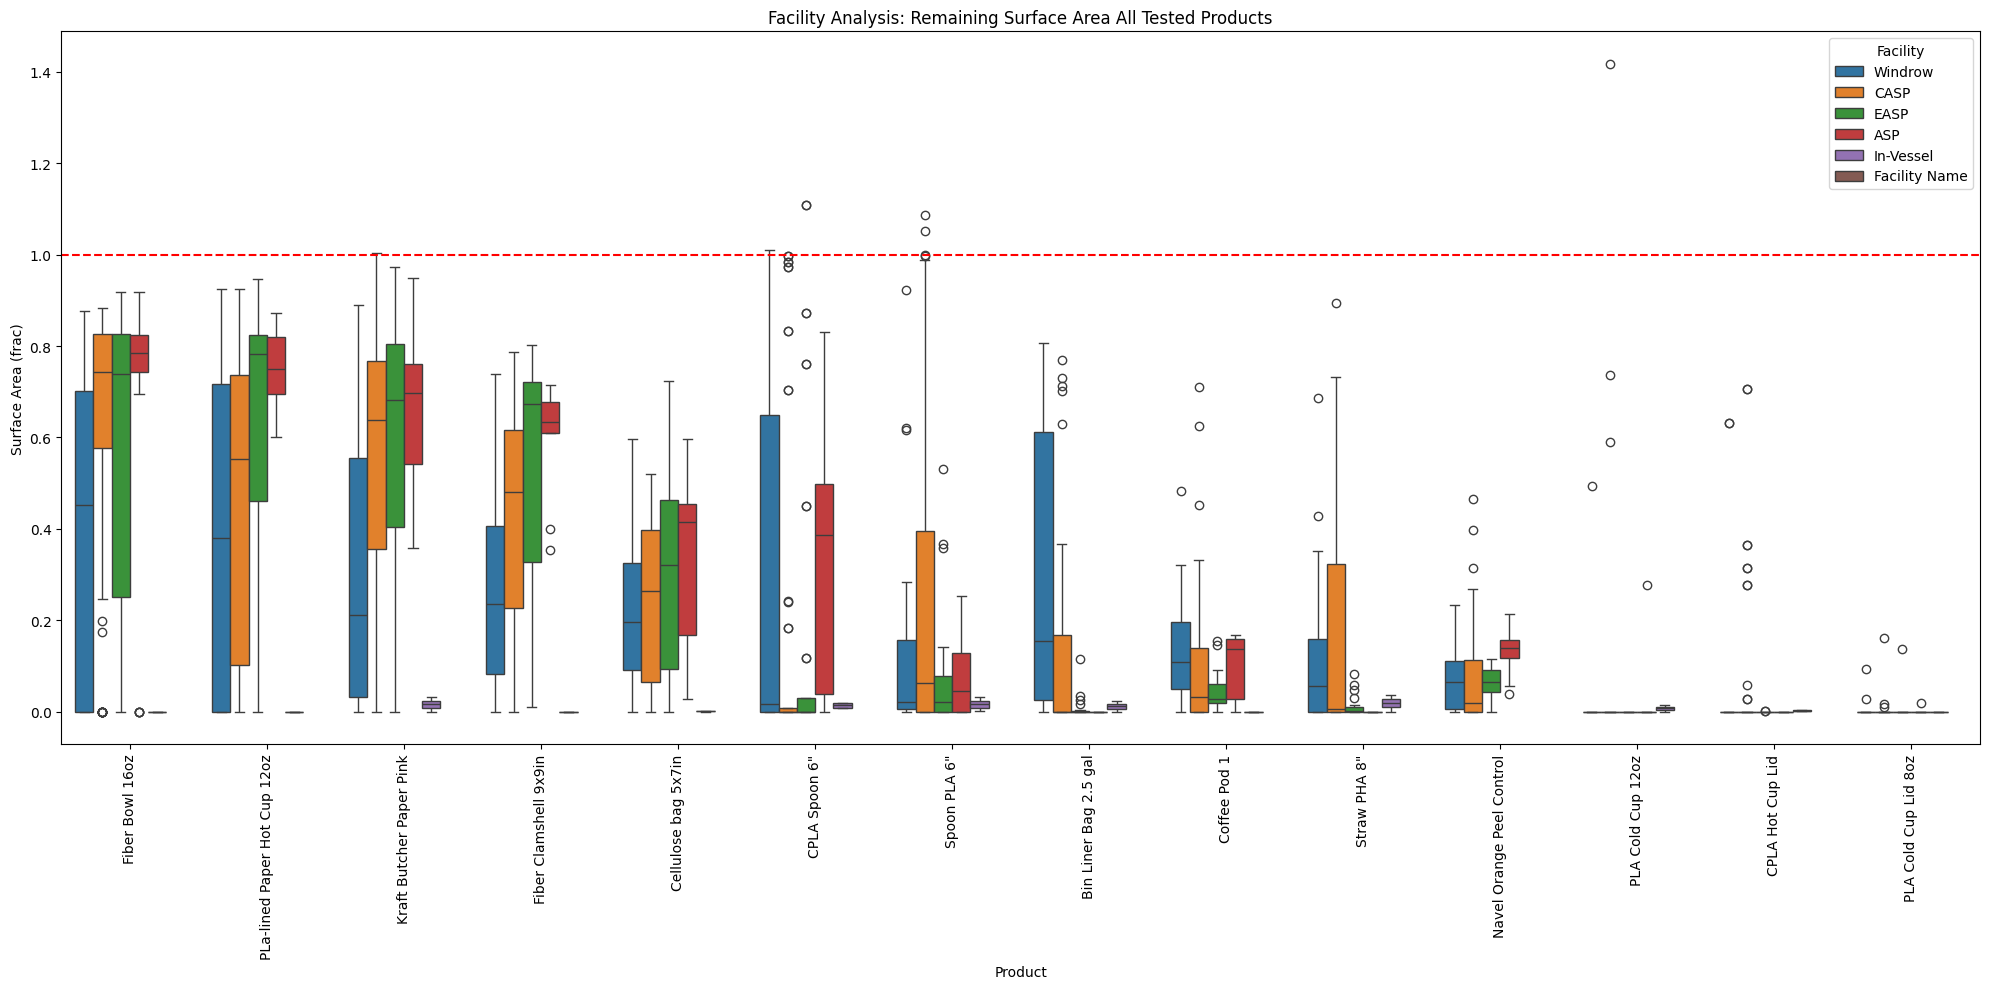

In [65]:
sa_long = pd.read_csv('/project/data/compiled_results/processed/observation_area.csv')
sa_long = sa_long[1:]
sa_long['percent_residual'] = pd.to_numeric(
    sa_long['percent_residual'], errors='coerce'
)

product_means = sa_long.groupby('product_name')['percent_residual'].mean()
sorted_products = product_means.sort_values(ascending=False).index.tolist()

plt.figure(figsize=(20, 10))
sns.boxplot(x='product_name', y='percent_residual', hue='facility_name', 
            data=sa_long, order=sorted_products)
plt.title('Facility Analysis: Remaining Surface Area All Tested Products')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Surface Area (frac)')
plt.axhline(y=1, color='r', linestyle='--') 
plt.legend(title='Facility')
plt.tight_layout()

## Phase Analysis

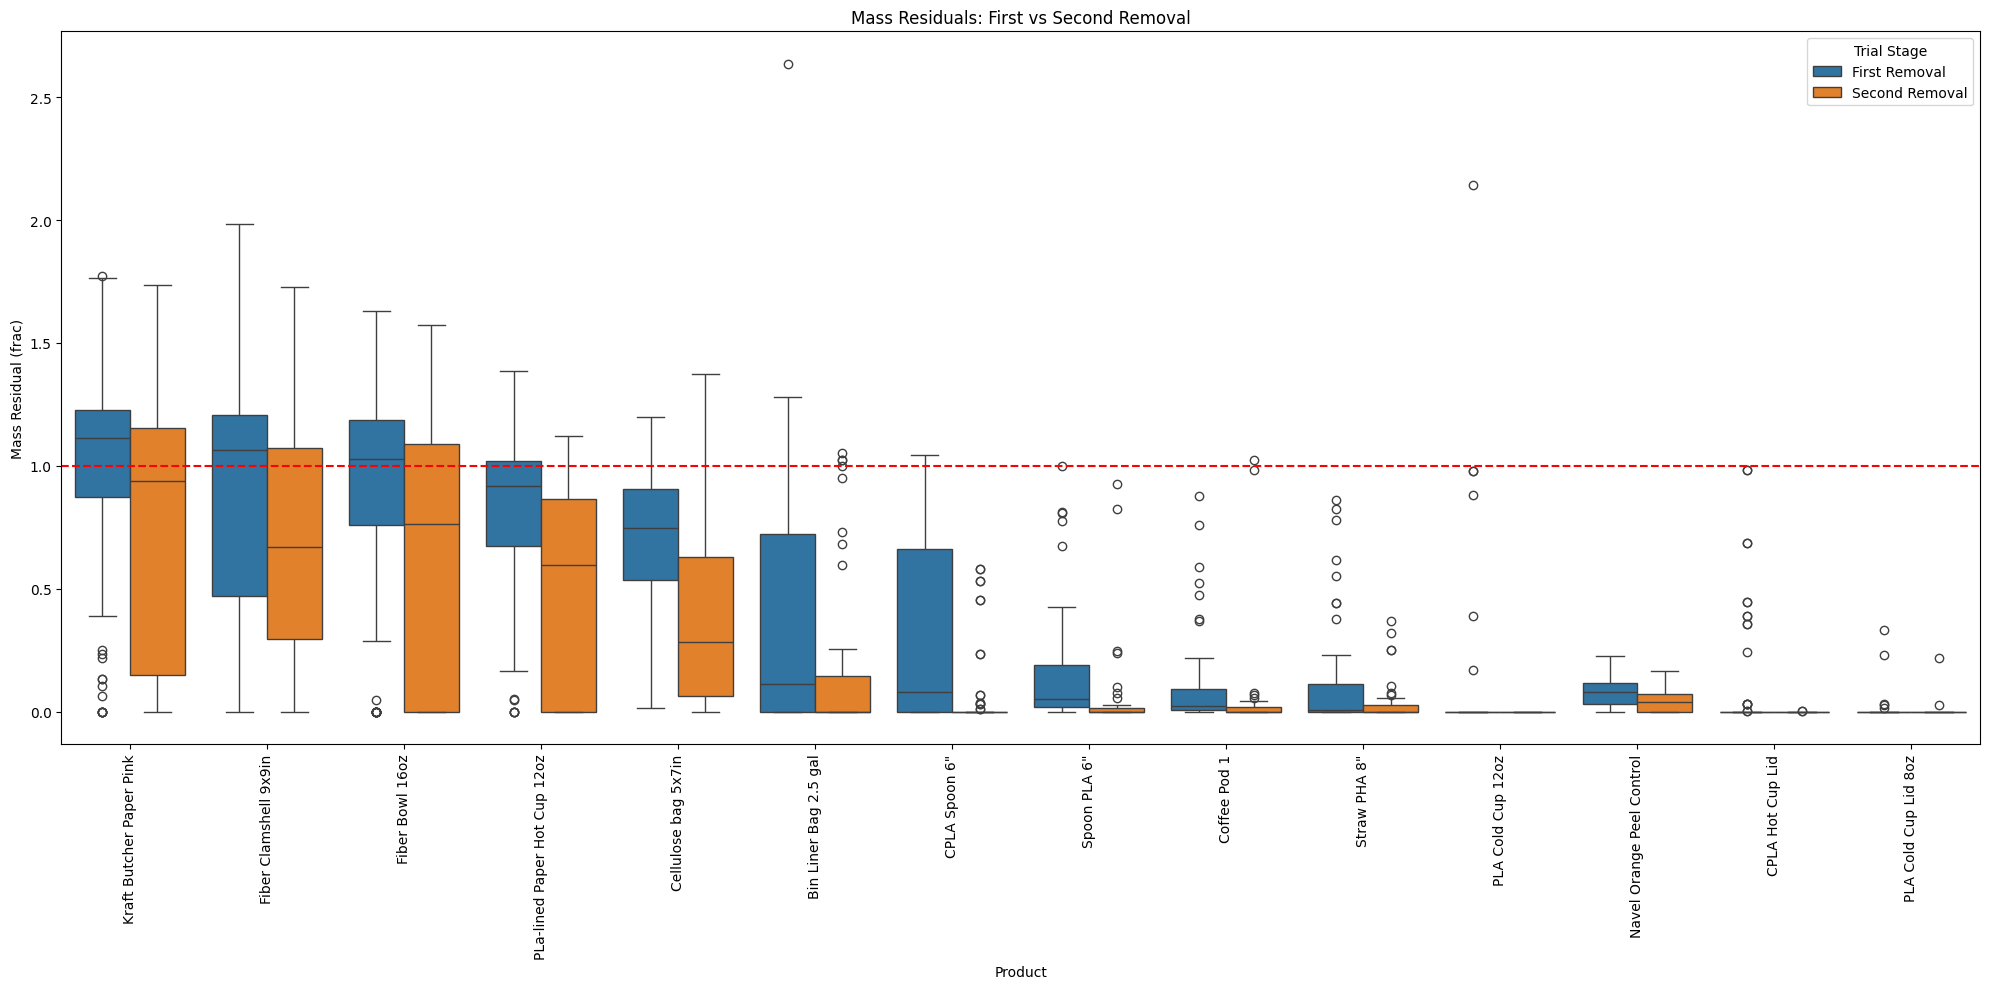

/tmp/ipykernel_366/973460631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_stages_filtered['percent_residual'] = pd.to_numeric(


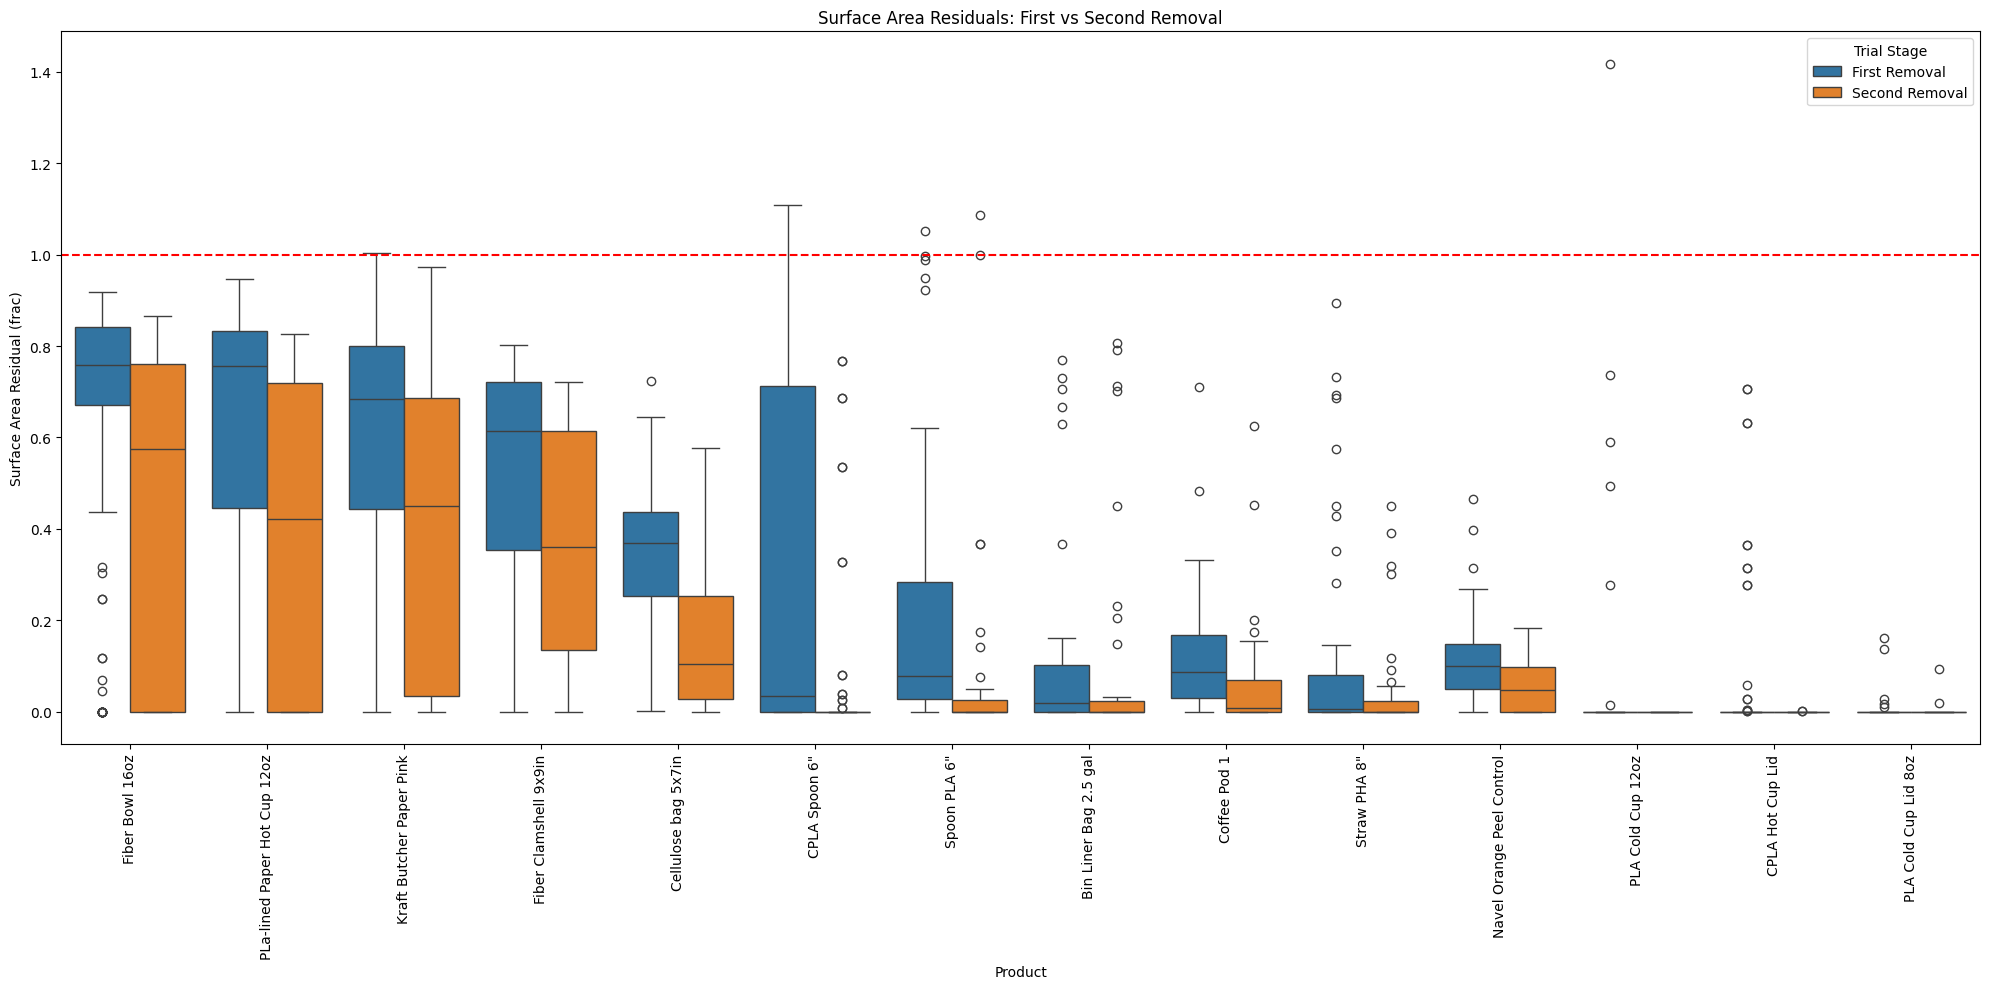

In [71]:
def phase_analysis(df, title, ylabel):
    trial_stages_filtered = df[df['trial_stage'].isin(
        ['First Removal', 'Second Removal'])
    ]
    trial_stages_filtered['percent_residual'] = pd.to_numeric(
        trial_stages_filtered['percent_residual'],
        errors='coerce')
    trial_stages_filtered_cleaned = trial_stages_filtered.dropna(
        subset=['percent_residual']
    )
    
    product_means = trial_stages_filtered_cleaned.groupby(
        'product_name'
    )['percent_residual'].mean()
    sorted_products = product_means.sort_values(ascending=False).index.tolist()
    
    plt.figure(figsize=(20, 10))
    sns.boxplot(x='product_name', y='percent_residual', hue='trial_stage', data=trial_stages_filtered_cleaned, order=sorted_products)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Product')
    plt.ylabel(ylabel)
    plt.axhline(y=1, color='r', linestyle='--')  # Add a horizontal line at y=1
    plt.legend(title='Trial Stage')
    plt.tight_layout()
    plt.show()


phase_analysis(mass_long, 'Mass Residuals: First vs Second Removal', 'Mass Residual (frac)')
phase_analysis(sa_long, 'Surface Area Residuals: First vs Second Removal', 'Surface Area Residual (frac)')

## Product Analysis

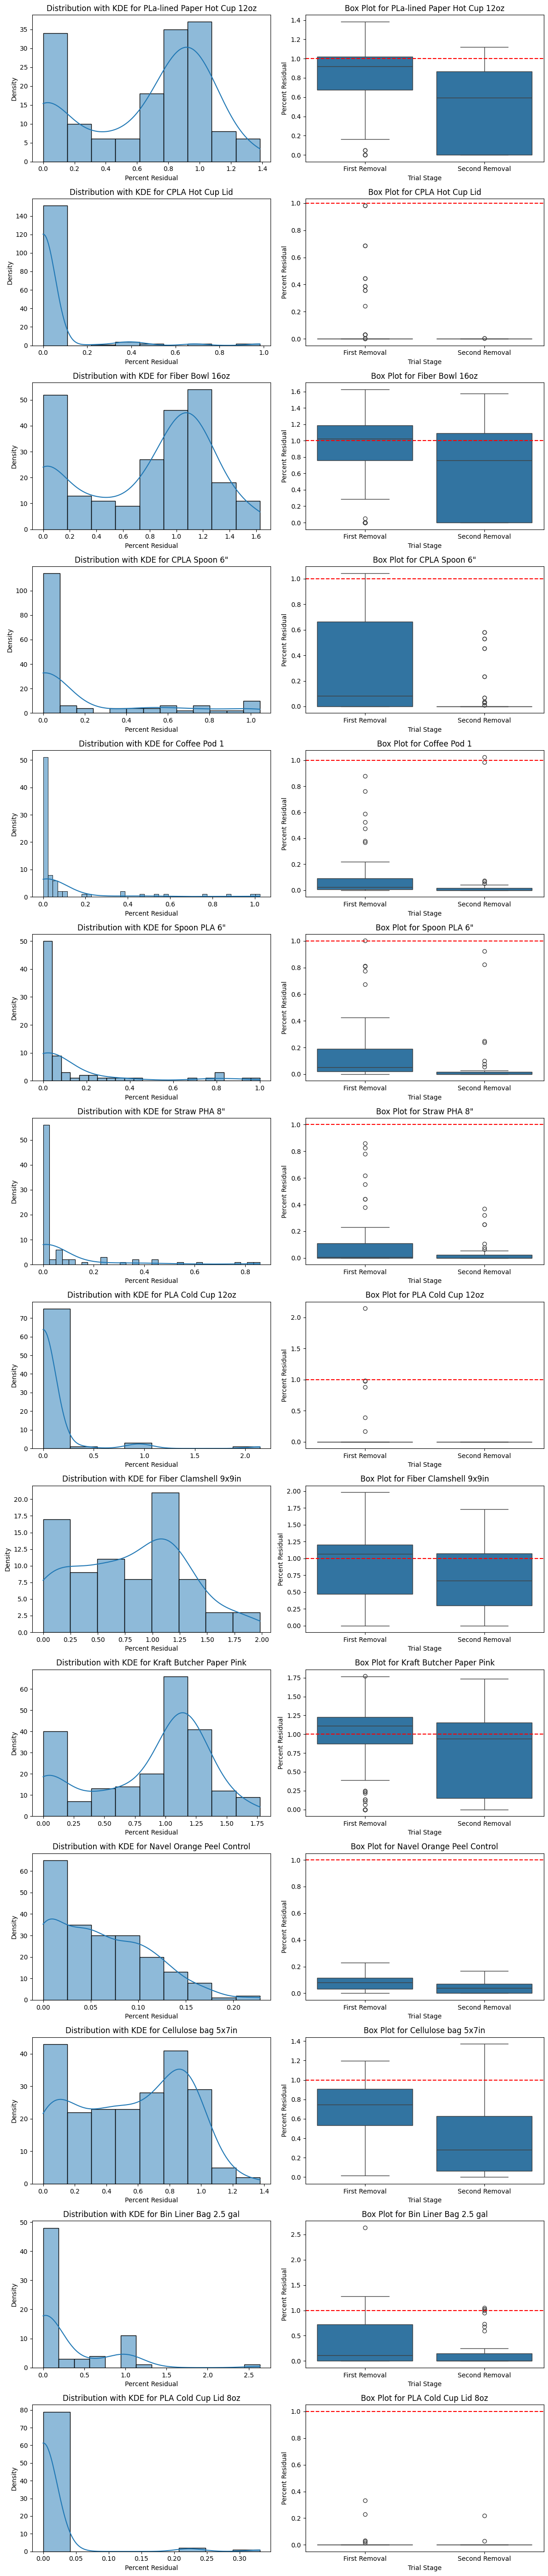

In [74]:
def product_analysis(data, selected_products):
    data_filtered = data[data['trial_stage'].isin(
        ['First Removal', 'Second Removal'])
    ]
    data_filtered['percent_residual'] = pd.to_numeric(
        data_filtered['percent_residual'], errors='coerce')
    
    data_filtered = data_filtered.dropna(subset=['percent_residual'])

    fig, axes = plt.subplots(nrows=len(selected_products),
                             ncols=2,
                             figsize=(12, 4 * len(selected_products)))

    if len(selected_products) == 1:
        axes = np.array([[axes,]])
    else:
        axes = axes.flatten()


    for row, product in enumerate(selected_products):
        sns.histplot(data_filtered[data_filtered['product_name'] == product]['percent_residual'], 
                     ax=axes[row*2], kde=True)
        axes[row*2].set_title(f'Distribution with KDE for {product}')
        axes[row*2].set_xlabel('Percent Residual')
        axes[row*2].set_ylabel('Density')

        sns.boxplot(x='trial_stage', y='percent_residual', data=data_filtered[data_filtered['product_name'] == product], 
                    ax=axes[row*2 + 1])
        axes[row*2 + 1].set_title(f'Box Plot for {product}')
        axes[row*2 + 1].set_xlabel('Trial Stage')
        axes[row*2 + 1].set_ylabel('Percent Residual')
        axes[row*2 + 1].axhline(y=1, color='r', linestyle='--')  # Add a horizontal line at y=1

    plt.tight_layout()
    plt.show()

selected_products = ['PLa-lined Paper Hot Cup 12oz',
                     'CPLA Hot Cup Lid',
                     'Fiber Bowl 16oz',
                     'CPLA Spoon 6"',
                     'Coffee Pod 1',
                     'Spoon PLA 6"',
                     'Straw PHA 8"',
                     'PLA Cold Cup 12oz',
                     'Fiber Clamshell 9x9in',
                     'Kraft Butcher Paper Pink',
                     'Navel Orange Peel Control',
                     'Cellulose bag 5x7in',
                     'Bin Liner Bag 2.5 gal',
                     'PLA Cold Cup Lid 8oz']

phase_analysis(mass_long, selected_products)

/tmp/ipykernel_366/3613347195.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['percent_residual'] = pd.to_numeric(data_filtered['percent_residual'], errors='coerce')


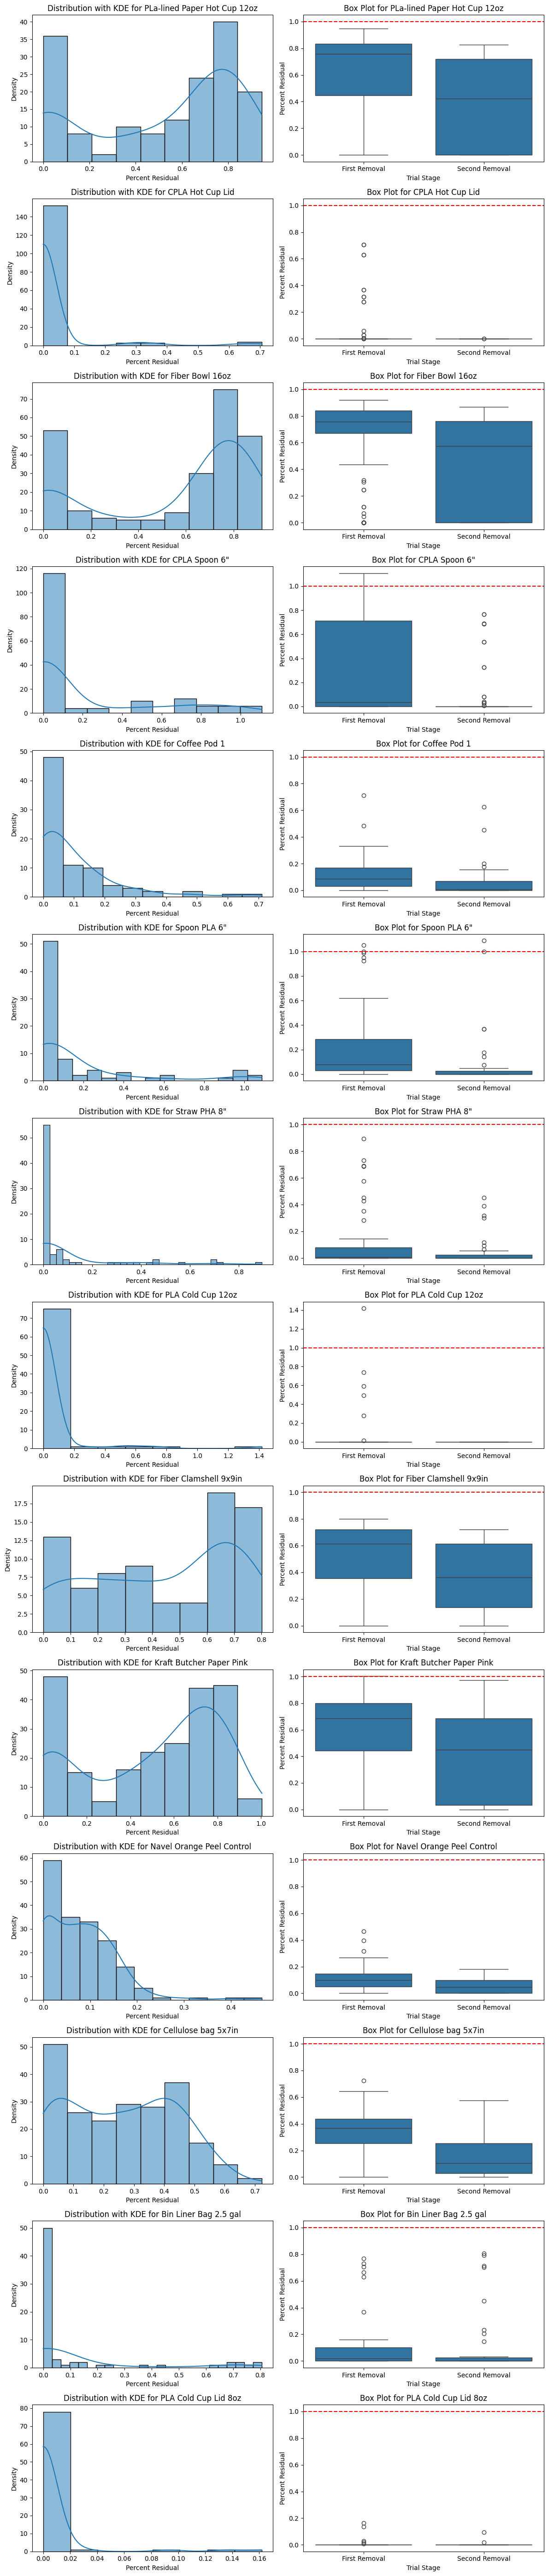

In [75]:
phase_analysis(sa_long, selected_products)